In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib

import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
data_normal_1 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_normal_2.csv')

data_attack_1 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/dataset_http_timeseries_attack_2.csv')

In [3]:
data_normal_1.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']
data_normal_2.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']

data_attack_1.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']
data_attack_2.columns = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url',
       'timeout', 'label']

In [4]:
features = ['no_thread', 'connection_time', 'r_bytes', 'port_src', 'status', 'url', 'timeout']

In [5]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values

X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']

Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']

X=np.concatenate((X_normal_1,X_normal_2,X_attack_1,X_attack_2))
Y=np.concatenate((Y_normal_1,Y_normal_2,Y_attack_1,Y_attack_2))

In [6]:
data_counter = Counter(Y)
print(data_counter)

Counter({1: 9370, 0: 1094})


In [7]:
over = SMOTE()
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, Y = pipeline.fit_resample(X, Y)

In [8]:
data_counter = Counter(Y)
print(data_counter)

Counter({0: 9370, 1: 9370})


In [9]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [10]:
print(np.shape(X))
print(np.shape(Y))

(18740, 7)
(18740,)


In [11]:
features = len(X[0])
samples = X.shape[0]
train_len = 50
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

In [12]:
for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [13]:
print(I.shape)

(18690, 50, 7)


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[50:], test_size = 0.2, stratify=Y[50:], random_state = 0)

In [15]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [16]:
model = create_baseline()

In [17]:
checkpoint = ModelCheckpoint("LSTMmodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [18]:
history = model.fit(X_train, Y_train, epochs = 30,validation_split=0.2, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/30
369/374 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.9902
Epoch 00001: val_loss improved from inf to 0.07809, saving model to LSTMmodel.h5
374/374 [==============================] - 7s 12ms/step - loss: 0.3034 - accuracy: 0.9899 - val_loss: 0.0781 - val_accuracy: 0.9926
Epoch 2/30
370/374 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9960
Epoch 00002: val_loss improved from 0.07809 to 0.06702, saving model to LSTMmodel.h5
374/374 [==============================] - 4s 11ms/step - loss: 0.0531 - accuracy: 0.9959 - val_loss: 0.0670 - val_accuracy: 0.9923
Epoch 3/30
374/374 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9962
Epoch 00003: val_loss improved from 0.06702 to 0.04608, saving model to LSTMmodel.h5
374/374 [==============================] - 4s 11ms/step - loss: 0.0492 - accuracy: 0.9962 - val_loss: 0.0461 - val_accuracy: 0.9967
Epoch 4/30
372/374 [============================>.] - ETA: 0s - l

Epoch 29/30
374/374 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9992
Epoch 00029: val_loss did not improve from 0.02855
374/374 [==============================] - 4s 10ms/step - loss: 0.0380 - accuracy: 0.9992 - val_loss: 0.0339 - val_accuracy: 0.9990
Epoch 00029: early stopping


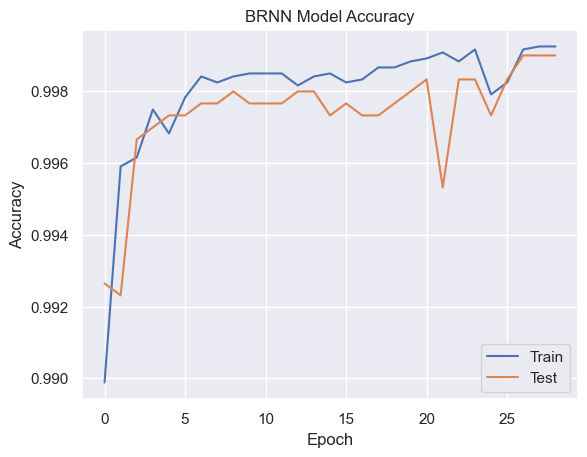

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN 500 Model Accuracy.png')
plt.show()

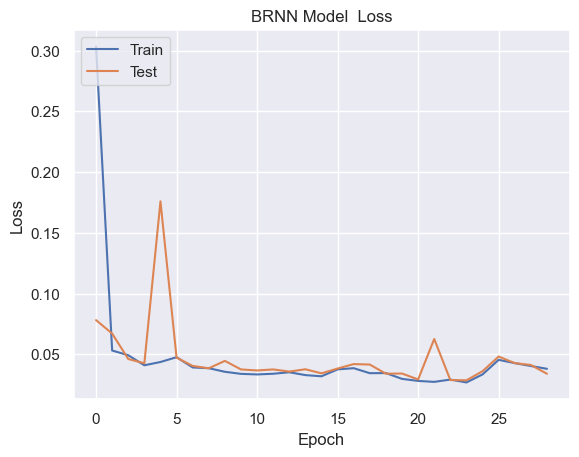

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN 50 Model Loss.png')
plt.show()

In [21]:
predict = model.predict(X_test, verbose=1)

117/117 [==============================] - 1s 4ms/step


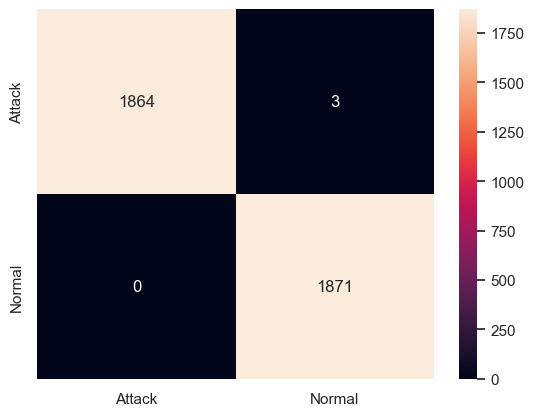

In [22]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [23]:
figure = ax.get_figure()
figure.savefig('confusion_matrix_BRNN_50.png', dpi=400)

In [24]:
model.save('brnn_model_50_step.h5')
joblib.dump(scalar, 'scaler_50.save')

['scaler_50.save']

In [25]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.92%


In [26]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1864
           1       1.00      1.00      1.00      1874

    accuracy                           1.00      3738
   macro avg       1.00      1.00      1.00      3738
weighted avg       1.00      1.00      1.00      3738



In [27]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=0.999


In [28]:
time_start = time.perf_counter()
predict = model.predict(I[:50], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

2/2 [==============================] - 0s 5ms/step
Time elapse for prediction : 0.03610419999999692
[[0.00133863]
 [0.00142864]
 [0.00147626]
 [0.00139455]
 [0.0015957 ]
 [0.00171368]
 [0.00178484]
 [0.00174566]
 [0.00137282]
 [0.00126453]
 [0.00127704]
 [0.00104258]
 [0.00101889]
 [0.00100166]
 [0.00106642]
 [0.00136023]
 [0.00168927]
 [0.0021472 ]
 [0.00219196]
 [0.00222508]
 [0.00216559]
 [0.0017228 ]
 [0.00163832]
 [0.00157106]
 [0.00159194]
 [0.00142666]
 [0.00119423]
 [0.00093442]
 [0.00089827]
 [0.00092394]
 [0.00100886]
 [0.00110681]
 [0.00102527]
 [0.00119092]
 [0.00141005]
 [0.00170392]
 [0.00162214]
 [0.00165265]
 [0.00155933]
 [0.00150661]
 [0.00136055]
 [0.00130812]
 [0.0012906 ]
 [0.00115828]
 [0.00113621]
 [0.00124623]
 [0.00128263]
 [0.00154193]
 [0.00156311]
 [0.00161242]]


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              36864     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 53,505
Trainable params: 53,505
Non-trainable params: 0
_________________________________________________________________
